In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from control import lqr, dare
from single_photons.estimators.kalman import KalmanFilter
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle

In [2]:
T = 293
rho = 2200
index_refraction = 1.4440
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
tweezer_waist = 0.6e-6
eta_detection = 1
delta_t = 3e-10
control_step = int(30*1e-9/delta_t) # defined as int, number of time steps of simulation necessary to compute the control policy
fs = 1/(control_step*delta_t)

cavity_waist = 100e-6
cavity_length = 50e-3
coupling = 6.68e-42

detuning_ratio = 0.25 #defined with respect to the particle's frequency
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 2.5

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection,\
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,\
                                     T = T, rho = rho, index_refraction = index_refraction)

In [3]:
period = 2 * np.pi / omega
t = np.arange(0, 5 * period, delta_t)
N = t.shape[0]

coupling = (1/(4*np.pi))*(ba_force**2)
coupling

4.1682488674527876e-42

In [4]:
g_0 = 0.19*omega
env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*g_0,
    coupling,
    radius=radius,
    rho=rho,
    eta_detection=eta_detection,
    T=T
)
std_detection

5.94865040519295e-11

In [7]:
pulse_amplitude = 6
pulse_center = 5000+int(1*t.shape[0]/2)
round_trip_time = 2*cavity_length/ct.c
#https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
pulse_width = trips*round_trip_time/delta_t
alpha_in = []
for i in range(t.shape[0]):
    alpha = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
        np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
    )
    alpha_in.append(alpha)
alpha_in = np.array(alpha_in)

In [ ]:
pulse_amplitude = 6
pulse_center = 5000+int(1*t.shape[0]/2)
round_trip_time = 2*cavity_length/ct.c
#https://www.rp-photonics.com/q_factor.html inverse of loss gives the average amount of round trips
trips = 1/(2*np.pi*round_trip_time*cavity_linewidth_ratio*omega)
pulse_width = trips*round_trip_time/delta_t
alpha_in = []
for i in range(t.shape[0]):
    alpha = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) * (
        np.exp(-((i - pulse_center) ** 2) / (2 * pulse_width**2))
    )
    alpha_in.append(alpha)
alpha_in = np.array(alpha_in)

In [8]:
alpha_in.shape

(208911,)

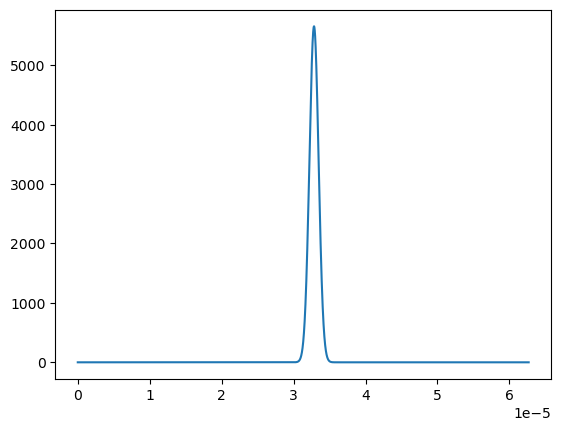

2116.7046933085485
35.99999999999979


In [60]:
plt.plot(t, alpha_in)
plt.show()
pulse_width
s=0
for el in alpha_in:
    s = s+el**2*delta_t
print(pulse_width)
print(s)

In [61]:
variance_process = env.thermal_force_std**2 + env.backaction_std**2
print(std_detection, variance_process,trips)

11.436084942324618 537605.4136351169 1903.7163086013177


In [62]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)*control_step*delta_t/2
if std_detection < 1:
    std_detection = std_detection/env.zp_x
R = np.array([[np.power(std_detection, 2)]])

In [63]:
g_fb = 5*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0, 0, 0],
                        [0, omega/2, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
(G_lqr, S, E) = lqr(env.A, env.B, cost_states, omega/(g_fb**2))
X, L, G = dare(Ad, Bd, cost_states, omega/(g_fb**2))
G_lqr, G

(array([[ -423091.04409609, -1170691.42473423,  2472451.16227934,
          2370561.86091444]]),
 array([[ -434540.21883067, -1127854.62216848,  2368082.29955347,
          2323914.10102493]]))

In [64]:
x0 = 0
P0 = np.matrix([[0,0,0,0],
               [0,0,0,0],
               [0,0,1,0],
               [0,0,0,1]])
estimation = np.matrix([[0], [0], [x0], [0]])
states = np.array([[0], [0], [x0], [0.0]])
G, omega, Ad, env.B*delta_t*control_step
new_states = np.zeros((N, 4))
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 4))
estimated_states[0, :] = estimation.reshape((4))
estimation = estimation.reshape((4, 1))
control = np.array([[0]])
controls = []
kalman = KalmanFilter(estimation, P0, Ad, Bd, env.C, Q, R)
for i in tqdm(range(t.shape[0])):
    new_states[i, :] = states[:, 0]
    if not i % control_step:
        measured_states[i] = states[2, 0] + std_detection * np.random.normal()
        kalman.propagate_dynamics(control)
        kalman.compute_aposteriori(measured_states[i])
        estimated_states[i, :] = kalman.estimates_aposteriori[int(i/control_step)][:, 0].reshape((4))
        estimation = estimated_states[i, :].reshape((4, 1))
        control = -np.matmul(G, estimation)
    else:
        measured_states[i] = measured_states[i-1]
        estimated_states[i, :] = estimated_states[i-1,:]

    controls.append(float(control))
    states = env.step(states, alpha_in=alpha_in[i], control=control, delta_t=delta_t)

  0%|                                                                                       | 0/208911 [00:00<?, ?it/s]C:\Users\jorge\AppData\Local\Temp\ipykernel_19260\1687899882.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i, :] = states[:, 0]
C:\Users\jorge\AppData\Local\Temp\ipykernel_19260\1687899882.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[2, 0] + std_detection * np.random.normal()
100%|████████████████████████████████████████████████████████████████████████| 208911/208911 [00:21<00:00, 9681.48it/s]


In [65]:
def compute_phonons(estimations, cov_matrix, step=100):
    sampled_cov_matrix = [el[2:,2:] for el in kalman.error_covariance_apriori[::step]]
    N = len(sampled_cov_matrix)
    phonons = np.zeros((N-1))
    for i in range(1, N):
        averaged = estimations[(i-1)*step:i*step, 2:].mean(axis=0)
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons[i-1] = np.trace(second_moments)/4-0.5
    return phonons

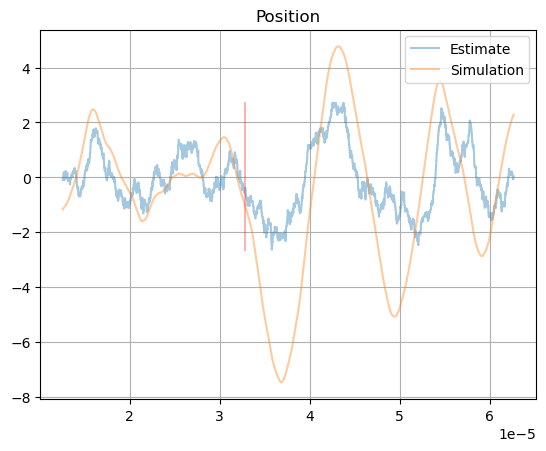

In [66]:
plt.close("all")
fig1 = plt.Figure()
plt.title("Position")
#plt.plot(t[int(1/5*t.shape[0]):], measured_states[int(1/5*t.shape[0]):], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):, 2], alpha = 0.4)
plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):, 2],alpha = 0.4)
plt.plot(2*[pulse_center*np.diff(t)[0]], [min(estimated_states[int(1/5*t.shape[0]):, 2]),max(estimated_states[int(1/5*t.shape[0]):, 2])],alpha = 0.3,color = 'red')
C = max(controls[int(1/5*t.shape[0]):])/max(measured_states[int(1/5*t.shape[0]):])
controls = [x/C for x in controls]
#plt.plot(t[int(1/5*t.shape[0]):], controls[int(1/5*t.shape[0]):], alpha = 0.3,color = 'black')
plt.grid()
plt.legend(["Estimate", "Simulation"],loc = 'upper right')
plt.show()

In [67]:
#plt.close("all")
#fig1 = plt.Figure()
#plt.title("Velocity")
#plt.plot(t[1:], estimated_states[1:, 3], alpha = 0.95)
#plt.plot(t[1:], new_states[1:, 3],alpha = 0.95)
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()

In [68]:
#plt.figure()
#fig2 = plt.Figure()
#plt.title('X quadrature')
#plt.plot(t[int(1/5*t.shape[0]):], estimated_states[int(1/5*t.shape[0]):,0])
#plt.plot(t[int(1/5*t.shape[0]):], new_states[int(1/5*t.shape[0]):,0])
#plt.grid()
#plt.legend(['Estimated','Simulated'])
#plt.show()

In [69]:

# In[63]:
#fig2 = plt.Figure()
#plt.figure()
#plt.title("Photon number")
#plt.plot(
#    t[1:], np.power(estimated_states[1:, 0], 2) + np.power(estimated_states[1:, 1], 2)
#)
#plt.plot(t[1:], np.power(new_states[1:, 0], 2) + np.power(new_states[1:, 1], 2))
#plt.grid()
#plt.legend(["Estimated", "Simulated"])
#plt.show()


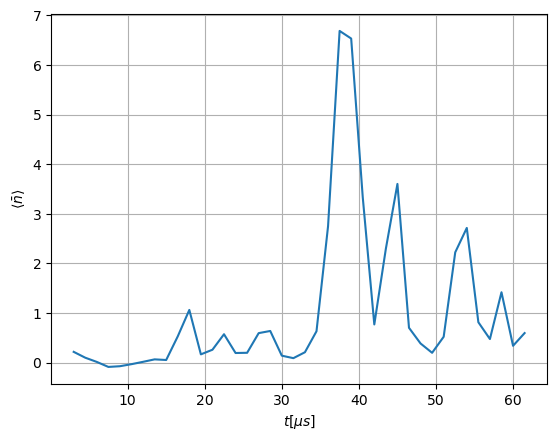

In [83]:
step=50
start = 1
phonons = compute_phonons(estimated_states[::control_step, :], kalman.error_covariance_aposteriori, step=step)
plt.plot(t[::control_step][::step][start+1:]/1e-6, phonons[start:])
#plt.plot(2*[pulse_center*np.diff(t)[0]/1e-6], [min(phonons[start:]),max(phonons[start:])],alpha = 0.2,color = 'green')
plt.ylabel(r'$\langle \bar{n} \rangle$')
plt.xlabel(r'$t[\mu s]$')
plt.grid()
plt.show()

4.834259234674931


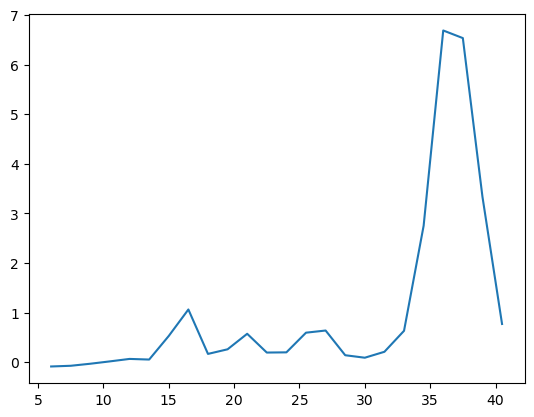

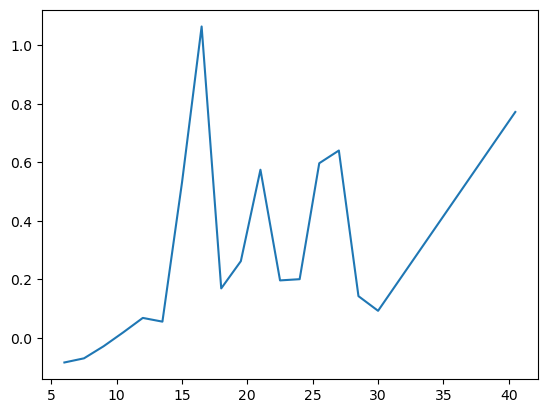

In [94]:
left = int((pulse_center-40*pulse_width)/(control_step*step))
right = int((pulse_center+15*pulse_width)/(control_step*step))
t_sample = t[::control_step][::step][left:right]
signal_sample = phonons[left:right]
if len(t_sample) > len(signal_sample):
    t_sample = t_sample[1:]
'''elif len(t_sample) < len(signal_sample):
    signal_sample = signal_sample[1:]'''
max_idx = np.where(signal_sample == max(signal_sample))[0][0]
signal_crop = np.append(signal_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                          signal_sample[max_idx + int(8*pulse_width/(control_step*step)):])
t_crop = np.append(t_sample[:max_idx - int(8*pulse_width/(control_step*step))],\
                          t_sample[max_idx + int(8*pulse_width/(control_step*step)):])

plt.figure()
plt.plot(t_sample/1e-6,signal_sample)
plt.figure()
plt.plot(t_crop/1e-6,signal_crop)

SNR = max(signal_sample)/(max(signal_crop) + np.std(signal_crop))
print(SNR)

In [19]:
print(kalman.error_covariance_apriori[-1], omega, g_cs, std_detection)

[[ 0.73500419  1.00990227 -0.52135936 -0.19066767]
 [ 1.00990227  1.93655015 -1.09902956  0.09322622]
 [-0.52135936 -1.09902956  1.27061144  0.40843908]
 [-0.19066767  0.09322622  0.40843908  1.03757578]] 501266.40589032974 96952.75519415858 11.436084942324618
